# Developing Quaternion and Space-time Number Tools for iPython3

In this notebook, tools for working with quaternions for physics issues are developed. The class QH treat quaternions as Hamilton would have done: as a 4-vector over the real numbers. 

In physics, group theory plays a central role in the fundamental forces of Nature via the standard model. The gauge symmetry U(1) a unit circle in the complex plane leads to electric charge conservation. The unit quaternions SU(2) is the symmetry needed for the weak force which leads to beta decay. The group SU(3) is the symmetry of the strong force that keeps a nucleus together.

The class Q8 was written in the hope that group theory would be written in first, not added as needed later. I call these "space-time numbers". The problem with such an approach is that one does not use the mathematical field of real numbers. Instead one relies on the set of positive reals. In some ways, this is like reverse engineering some basic computer science. Libraries written in C have a notion of a signed versus unsigned integer. The signed integer behaves like the familiar integers. The unsigned integer is like the positive integers. The difference between the two is whether there is a placeholder for the sign or not. All floats are signed. The modulo operations that work for unsigned integers does not work for floats.

Test driven development was used. The same tests for class QH were used for Q8.  Either class can be used to study quaternions in physics.

In [1]:
import IPython
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import os
import unittest
from os.path import basename
from glob import glob
from sympy import *
%matplotlib inline 

Define the stretch factor $\gamma$ and the $\gamma \beta$ used in special relativity.

In [2]:
def sr_gamma(beta_x=0, beta_y=0, beta_z=0):
    """The gamma used in special relativity using 3 velocites, some may be zero."""

    return 1 / (1 - beta_x ** 2 - beta_y ** 2 - beta_z ** 2) ** 0.5

def sr_gamma_betas(beta_x=0, beta_y=0, beta_z=0):
    """gamma and the three gamma * betas used in special relativity."""

    g = sr_gamma(beta_x, beta_y, beta_z)
    
    return [g, g * beta_x, g * beta_y, g * beta_z]

Define a class QH to manipulate quaternions as Hamilton would have done it so many years ago. The "qtype" is a little bit of text to leave a trail of breadcrumbs about how a particular quaternion was generated.

In [3]:
class QH:
    """Quaternions as Hamilton would have defined them, on the manifold R^4."""

    def __init__(self, values=None, qtype="Q"):
        if values is None:
            self.t, self.x, self.y, self.z = 0, 0, 0, 0
        elif len(values) == 4:
            self.t, self.x, self.y, self.z = values[0], values[1], values[2], values[3]

        elif len(values) == 8:
            self.t, self.x = values[0] - values[1], values[2] - values[3]
            self.y, self.z = values[4] - values[5], values[6] - values[7]
        self.qtype = qtype

    def __str__(self):
        """Customize the output."""
        return "{t}t  {x}i  {y}j  {z}k  {qt}".format(t=self.t, x=self.x, y=self.y, z=self.z, qt=self.qtype)
        
    def q_0(self, qtype="Zero"):
        """Return a zero quaternion."""

        return QH([0, 0, 0, 0], qtype=qtype)

    def q_1(self, qtype="One"):
        """Return a multiplicative identity quaternion."""

        return QH([1, 0, 0, 0], qtype=qtype)
    
    def dupe(self, qtype=""):
        """Return a duplicate copy, good for testing since qtypes persist"""
        
        return QH([self.t, self.x, self.y, self.z], qtype=self.qtype)
    
    def conj(self, conj_type=0, qtype="*"):
        """Three types of conjugates."""

        t, x, y, z = self.t, self.x, self.y, self.z
        conjq = QH(qtype=self.qtype)

        if conj_type == 0:
            conjq.t = t
            conjq.x = -1 * x
            conjq.y = -1 * y
            conjq.z = -1 * z

        if conj_type == 1:
            conjq.t = -1 * t
            conjq.x = x
            conjq.y = -1 * y
            conjq.z = -1 * z
            qtype += "1"
            
        if conj_type == 2:
            conjq.t = -1 * t
            conjq.x = -1 * x
            conjq.y = y
            conjq.z = -1 * z
            qtype += "2"
            
        conjq.add_qtype(qtype)
        return conjq

    def add_qtype(self, qtype):
        """Adds a qtype to an exiting qtype."""
        
        self.qtype += "." + qtype
    
    def commuting_products(self, q1):
        """Returns a dictionary with the commuting products."""

        s_t, s_x, s_y, s_z = self.t, self.x, self.y, self.z
        q1_t, q1_x, q1_y, q1_z = q1.t, q1.x, q1.y, q1.z

        products = {'tt': s_t * q1_t,
                    'xx+yy+zz': s_x * q1_x + s_y * q1_y + s_z * q1_z,
                    'tx+xt': s_t * q1_x + s_x * q1_t,
                    'ty+yt': s_t * q1_y + s_y * q1_t,
                    'tz+zt': s_t * q1_z + s_z * q1_t}

        return products

    def anti_commuting_products(self, q1):
        """Returns a dictionary with the three anti-commuting products."""

        s_x, s_y, s_z = self.x, self.y, self.z
        q1_x, q1_y, q1_z = q1.x, q1.y, q1.z

        products = {'yz-zy': s_y * q1_z - s_z * q1_y,
                    'zx-xz': s_z * q1_x - s_x * q1_z,
                    'xy-yx': s_x * q1_y - s_y * q1_x
                    }

        return products

    def all_products(self, q1):
        """Returns a dictionary with all possible products."""

        products = self.commuting_products(q1)
        products.update(self.anti_commuting_products(q1))

        return products

    def square(self, qtype="sq"):
        """Square a quaternion."""

        qxq = self.commuting_products(self)

        sq_q = QH(qtype=self.qtype)
        sq_q.t = qxq['tt'] - qxq['xx+yy+zz']
        sq_q.x = qxq['tx+xt']
        sq_q.y = qxq['ty+yt']
        sq_q.z = qxq['tz+zt']

        sq_q.add_qtype(qtype)
        return sq_q

    def norm_squared(self, qtype="norm_squared"):
        """The norm_squared of a quaternion."""

        qxq = self.commuting_products(self)

        n_q = QH(qtype=self.qtype)
        n_q.t = qxq['tt'] + qxq['xx+yy+zz']

        n_q.add_qtype(qtype)
        return n_q

    def norm_squared_of_vector(self, qtype="norm_squaredV"):
        """The norm_squared of the vector of a quaternion."""

        qxq = self.commuting_products(self)

        nv_q = QH(qtype=self.qtype)
        nv_q.t = qxq['xx+yy+zz']

        nv_q.add_qtype(qtype)
        return nv_q

    def abs_of_q(self, qtype="abs"):
        """The absolute value, the square root of the norm_squared."""

        a = self.norm_squared()
        sqrt_t = a.t ** 0.5
        a.t = sqrt_t

        a.qtype = self.qtype
        a.add_qtype(qtype)
        return a

    def abs_of_vector(self, qtype="absV"):
        """The absolute value of the vector, the square root of the norm_squared of the vector."""

        av = self.norm_squared_of_vector()
        sqrt_t = av.t ** 0.5
        av.t = sqrt_t

        av.qtype = self.qtype
        av.add_qtype(qtype)
        return av

    def add(self, qh_1, qtype=""):
        """Form a add given 2 quaternions."""

        t_1, x_1, y_1, z_1 = self.t, self.x, self.y, self.z
        t_2, x_2, y_2, z_2 = qh_1.t, qh_1.x, qh_1.y, qh_1.z

        add_q = QH()
        add_q.t = t_1 + t_2
        add_q.x = x_1 + x_2
        add_q.y = y_1 + y_2
        add_q.z = z_1 + z_2
        
        if qtype:
            add_q.qtype = qtype
        else:
            add_q.qtype = "{f}+{s}".format(f=self.qtype, s=qh_1.qtype)
        
        return add_q    

    def dif(self, qh_1, qtype=""):
        """Form a add given 2 quaternions."""

        t_1, x_1, y_1, z_1 = self.t, self.x, self.y, self.z
        t_2, x_2, y_2, z_2 = qh_1.t, qh_1.x, qh_1.y, qh_1.z

        dif_q = QH()
        dif_q.t = t_1 - t_2
        dif_q.x = x_1 - x_2
        dif_q.y = y_1 - y_2
        dif_q.z = z_1 - z_2

        if qtype:
            dif_q.qtype = qtype
        else:
            dif_q.qtype = "{f}-{s}".format(f=self.qtype, s=qh_1.qtype)
            
        return dif_q

    def product(self, q1, qtype=""):
        """Form a product given 2 quaternions."""

        qxq = self.all_products(q1)
        pq = QH()
        pq.t = qxq['tt'] - qxq['xx+yy+zz']
        pq.x = qxq['tx+xt'] + qxq['yz-zy']
        pq.y = qxq['ty+yt'] + qxq['zx-xz']
        pq.z = qxq['tz+zt'] + qxq['xy-yx']
            
        if qtype:
            pq.qtype = qtype
        else:
            pq.qtype = "{f}x{s}".format(f=self.qtype, s=q1.qtype)
            
        return pq

    def invert(self, qtype="^-1"):
        """The inverse of a quaternion."""

        q_conj = self.conj()
        q_norm_squared = self.norm_squared()

        if q_norm_squared.t == 0:
            print("oops, zero on the norm_squared.")
            return self.q0()

        q_norm_squared_inv = QH([1.0 / q_norm_squared.t, 0, 0, 0])
        q_inv = q_conj.product(q_norm_squared_inv, qtype=self.qtype)
        
        q_inv.add_qtype(qtype)
        return q_inv

    def divide_by(self, q1, qtype=""):
        """Divide one quaternion by another. The order matters unless one is using a norm_squared (real number)."""

        q1_inv = q1.invert()
        q_div = self.product(q1.invert())
        
        if qtype:
            q_div.qtype = qtype
        else:
            q_div.qtype = "{f}/{s}".format(f=self.qtype, s=q1.qtype)
            
        return q_div

    def triple_product(self, q1, q2):
        """Form a triple product given 3 quaternions."""

        triple = self.product(q1).product(q2)
        return triple

    # Quaternion rotation involves a triple product:  UQU∗
    # where the U is a unitary quaternion (having a norm_squared of one).
    def rotate(self, a_1=0, a_2=0, a_3=0, qtype="rot"):
        """Do a rotation given up to three angles."""

        u = QH([0, a_1, a_2, a_3])
        u_abs = u.abs_of_q()
        u_norm_squaredalized = u.divide_by(u_abs)

        q_rot = u_norm_squaredalized.triple_product(self, u_norm_squaredalized.conj())
  
        q_rot.qtype = self.qtype
        q_rot.add_qtype(qtype)
        return q_rot

    # A boost also uses triple products like a rotation, but more of them.
    # This is not a well-known result, but does work.
    # b -> b' = h b h* + 1/2 ((hhb)* -(h*h*b)*)
    # where h is of the form (cosh(a), sinh(a))
    def boost(self, beta_x=0, beta_y=0, beta_z=0, qtype="boost"):
        """A boost along the x, y, and/or z axis."""

        boost = QH(sr_gamma_betas(beta_x, beta_y, beta_z))      
        b_conj = boost.conj()

        triple_1 = boost.triple_product(self, b_conj)
        triple_2 = boost.triple_product(boost, self).conj()
        triple_3 = b_conj.triple_product(b_conj, self).conj()
      
        triple_23 = triple_2.dif(triple_3)
        half_23 = triple_23.product(QH([0.5, 0, 0, 0]))
        triple_123 = triple_1.add(half_23, qtype=self.qtype)
        
        triple_123.add_qtype(qtype)
        return triple_123

    # g_shift is a function based on the space-times-time invariance proposal for gravity,
    # which proposes that if one changes the distance from a gravitational source, then
    # squares a measurement, the observers at two different hieghts agree to their
    # space-times-time values, but not the intervals.
    # g_form is the form of the function, either minimal or exponential
    # Minimal is what is needed to pass all weak field tests of gravity
    def g_shift(self, dimensionless_g, g_form="exp", qtype="g_shift"):
        """Shift an observation based on a dimensionless GM/c^2 dR."""

        if g_form == "exp":
            g_factor = exp(dimensionless_g)
        elif g_form == "minimal":
            g_factor = 1 + 2 * dimensionless_g + 2 * dimensionless_g ** 2
        else:
            print("g_form not defined, should be 'exp' or 'minimal': {}".format(g_form))
            return self

        g_q = QH(qtype=self.qtype)
        g_q.t = self.t / g_factor
        g_q.x = self.x * g_factor
        g_q.y = self.y * g_factor
        g_q.z = self.z * g_factor

        g_q.add_qtype(qtype)
        return g_q

Write tests the QH class.

In [4]:
class TestQH(unittest.TestCase):
    """Class to make sure all the functions work as expected."""

    Q = QH([1, -2, -3, -4], qtype="Q")
    P = QH([0, 4, -3, 0], qtype="P")
    verbose = True

    def test_qt(self):
        q1 = self.Q.dupe()
        self.assertTrue(q1.t == 1)

    def test_q0(self):
        q1 = self.Q.dupe()
        q_z = q1.q_0()
        if self.verbose: print("q0: {}".format(q_z))
        self.assertTrue(q_z.t == 0)
        self.assertTrue(q_z.x == 0)
        self.assertTrue(q_z.y == 0)
        self.assertTrue(q_z.z == 0)

    def test_q1(self):
        q1 = self.Q.dupe()
        q_z = q1.q_1()
        if self.verbose: print("q1: {}".format(q_z))
        self.assertTrue(q_z.t == 1)
        self.assertTrue(q_z.x == 0)
        self.assertTrue(q_z.y == 0)
        self.assertTrue(q_z.z == 0)

    def test_conj_0(self):
        q1 = self.Q.dupe()
        q_z = q1.conj()
        if self.verbose: print("q_conj 0: {}".format(q_z))
        self.assertTrue(q_z.t == 1)
        self.assertTrue(q_z.x == 2)
        self.assertTrue(q_z.y == 3)
        self.assertTrue(q_z.z == 4)

    def test_conj_1(self):
        q1 = self.Q.dupe()
        q_z = q1.conj(1)
        if self.verbose: print("q_conj 1: {}".format(q_z))
        self.assertTrue(q_z.t == -1)
        self.assertTrue(q_z.x == -2)
        self.assertTrue(q_z.y == 3)
        self.assertTrue(q_z.z == 4)

    def test_conj_2(self):
        q1 = self.Q.dupe()
        q_z = q1.conj(2)
        if self.verbose: print("q_conj 2: {}".format(q_z))
        self.assertTrue(q_z.t == -1)
        self.assertTrue(q_z.x == 2)
        self.assertTrue(q_z.y == -3)
        self.assertTrue(q_z.z == 4)

    def test_square(self):
        q1 = self.Q.dupe()
        q_z = q1.square()
        if self.verbose: print("square: {}".format(q_z))
        self.assertTrue(q_z.t == -28)
        self.assertTrue(q_z.x == -4)
        self.assertTrue(q_z.y == -6)
        self.assertTrue(q_z.z == -8)

    def test_norm_squared(self):
        q1 = self.Q.dupe()
        q_z = q1.norm_squared()
        if self.verbose: print("norm_squared: {}".format(q_z))
        self.assertTrue(q_z.t == 30)
        self.assertTrue(q_z.x == 0)
        self.assertTrue(q_z.y == 0)
        self.assertTrue(q_z.z == 0)

    def test_norm_squared_of_vector(self):
        q1 = self.Q.dupe()
        q_z = q1.norm_squared_of_vector()
        if self.verbose: print("norm_squared_of_vector: {}".format(q_z))
        self.assertTrue(q_z.t == 29)
        self.assertTrue(q_z.x == 0)
        self.assertTrue(q_z.y == 0)
        self.assertTrue(q_z.z == 0)
        
    def test_abs_of_q(self):
        q2 = self.P.dupe()
        q_z = q2.abs_of_q()
        if self.verbose: print("abs_of_q: {}".format(q_z))
        self.assertTrue(q_z.t == 5)
        self.assertTrue(q_z.x == 0)
        self.assertTrue(q_z.y == 0)
        self.assertTrue(q_z.z == 0)
        
    def test_abs_of_vector(self):
        q2 = self.P.dupe()
        q_z = q2.abs_of_vector()
        if self.verbose: print("abs_of_vector: {}".format(q_z))
        self.assertTrue(q_z.t == 5)
        self.assertTrue(q_z.x == 0)
        self.assertTrue(q_z.y == 0)
        self.assertTrue(q_z.z == 0)
        
    def test_add(self):
        q1 = self.Q.dupe()
        q2 = self.P.dupe()
        q_z = q1.add(q2)
        if self.verbose: print("add: {}".format(q_z))
        self.assertTrue(q_z.t == 1)
        self.assertTrue(q_z.x == 2)
        self.assertTrue(q_z.y == -6)
        self.assertTrue(q_z.z == -4)
        
    def test_dif(self):
        q1 = self.Q.dupe()
        q2 = self.P.dupe()
        q_z = q1.dif(q2)
        if self.verbose: print("dif: {}".format(q_z))
        self.assertTrue(q_z.t == 1)
        self.assertTrue(q_z.x == -6)
        self.assertTrue(q_z.y == 0)
        self.assertTrue(q_z.z == -4) 

    def test_product(self):
        q1 = self.Q.dupe()
        q2 = self.P.dupe()
        q_z = q1.product(q2)
        if self.verbose: print("product: {}".format(q_z))
        self.assertTrue(q_z.t == -1)
        self.assertTrue(q_z.x == -8)
        self.assertTrue(q_z.y == -19)
        self.assertTrue(q_z.z == 18)
        
    def test_invert(self):
        q1 = self.Q.dupe()
        q2 = self.P.dupe()
        q_z = q2.invert()
        if self.verbose: print("invert: {}".format(q_z))
        self.assertTrue(q_z.t == 0)
        self.assertTrue(q_z.x == -0.16)
        self.assertTrue(q_z.y == 0.12)
        self.assertTrue(q_z.z == 0)
                
    def test_divide_by(self):
        q1 = self.Q.dupe()
        q_z = q1.divide_by(q1)
        if self.verbose: print("divide_by: {}".format(q_z))
        self.assertTrue(q_z.t == 1)
        self.assertTrue(q_z.x == 0)
        self.assertTrue(q_z.y == 0)
        self.assertTrue(q_z.z == 0) 
        
    def test_triple_product(self):
        q1 = self.Q.dupe()
        q2 = self.P.dupe()
        q_z = q1.triple_product(q2, q1)
        if self.verbose: print("triple product: {}".format(q_z))
        self.assertTrue(q_z.t == -2)
        self.assertTrue(q_z.x == 124)
        self.assertTrue(q_z.y == -84)
        self.assertTrue(q_z.z == 8)
        
    def test_rotate(self):
        q1 = self.Q.dupe()
        q_z = q1.rotate(1)
        if self.verbose: print("rotate: {}".format(q_z))
        self.assertTrue(q_z.t == 1)
        self.assertTrue(q_z.x == -2)
        self.assertTrue(q_z.y == 3)
        self.assertTrue(q_z.z == 4)
        
    def test_boost(self):
        q1 = self.Q.dupe()
        q1_sq = q1.square()
        q_z = q1.boost(0.003)
        q_z2 = q_z.square()
        if self.verbose: print("q1_sq: {}".format(q1_sq))
        if self.verbose: print("boosted: {}".format(q_z))
        if self.verbose: print("boosted squared: {}".format(q_z2))
        print("{}")
        self.assertTrue(round(q_z2.t, 5) == round(q1_sq.t, 5))

    def test_g_shift(self):
        q1 = self.Q.dupe()
        q1_sq = q1.square()
        q_z = q1.g_shift(0.003)
        q_z2 = q_z.square()
        q_z_minimal = q1.g_shift(0.003, g_form="minimal")
        q_z2_minimal = q_z_minimal.square()
        if self.verbose: print("q1_sq: {}".format(q1_sq))
        if self.verbose: print("g_shift: {}".format(q_z))
        if self.verbose: print("g squared: {}".format(q_z2))
        self.assertTrue(q_z2.t != q1_sq.t)
        self.assertTrue(q_z2.x == q1_sq.x)
        self.assertTrue(q_z2.y == q1_sq.y)
        self.assertTrue(q_z2.z == q1_sq.z)
        self.assertTrue(q_z2_minimal.t != q1_sq.t)
        self.assertTrue(q_z2_minimal.x == q1_sq.x)
        self.assertTrue(q_z2_minimal.y == q1_sq.y)
        self.assertTrue(q_z2_minimal.z == q1_sq.z)

In [5]:
suite = unittest.TestLoader().loadTestsFromModule(TestQH())
unittest.TextTestRunner().run(suite);

....................

abs_of_q: 5.0t  0i  0j  0k  P.abs
abs_of_vector: 5.0t  0i  0j  0k  P.absV
add: 1t  2i  -6j  -4k  Q+P
q1_sq: -28t  -4i  -6j  -8k  Q.sq
boosted: 1.0120181081629736t  -2.006036054324489i  -3.0j  -4.0k  Q.boost
boosted squared: -28.0t  -4.0602896252083704i  -6.072108648977841j  -8.096144865303788k  Q.boost.sq
{}
q_conj 0: 1t  2i  3j  4k  Q.*
q_conj 1: -1t  -2i  3j  4k  Q.*1
q_conj 2: -1t  2i  -3j  4k  Q.*2
dif: 1t  -6i  0j  -4k  Q-P
divide_by: 1.0t  0.0i  0.0j  0.0k  Q/Q
q1_sq: -28t  -4i  -6j  -8k  Q.sq
g_shift: 0.997004495503373t  -2.00600900900675i  -3.00901351351013j  -4.01201801801351k  Q.g_shift
g squared: -28.1805050815139t  -4.00000000000000i  -6.00000000000000j  -8.00000000000000k  Q.g_shift.sq
invert: 0.0t  -0.16i  0.12j  0.0k  P.^-1
norm_squared: 30t  0i  0j  0k  Q.norm_squared
norm_squared_of_vector: 29t  0i  0j  0k  Q.norm_squaredV
product: -1t  -8i  -19j  18k  QxP
q0: 0t  0i  0j  0k  Zero
q1: 1t  0i  0j  0k  One
rotate: 1.0t  -2.0i  3.0j  4.0k  Q.rot
square: -28t  -4i  -6j  -8


----------------------------------------------------------------------
Ran 20 tests in 0.054s

OK


My long term goal is to deal with quaternions on a quaternion manifold. This will have 4 pairs of doublets. Each doublet is paired with its additive inverse. Instead of using real numbers, one uses (3, 0) and (0, 2) to represent +3 and -2 respectively. Numbers such as (5, 6) are allowed. That can be "reduced" to (0, 1).  My sense is that somewhere deep in the depths of relativistic quantum field theory, this will be a "good thing". For now, it is a minor pain to program.

In [6]:
class Doublet:
    """A pair of number that are additive inverses. It can take
    ints, floats, Symbols, or strings."""
    
    def __init__(self, numbers=None):
        
        if numbers is None:
            self.p = 0
            self.n = 0
            
        elif isinstance(numbers, (int, float)):
            if numbers < 0:
                self.n = -1 * numbers
                self.p = 0
            else:
                self.p = numbers
                self.n = 0
        
        elif isinstance(numbers, Symbol):
            self.p = numbers
            self.n = 0
            
        elif isinstance(numbers, list):
            
            if len(numbers) == 2:
                self.p = numbers[0]
                self.n = numbers[1]

                      
        elif isinstance(numbers, str):
            n_list = numbers.split()
            
            if (len(n_list) == 1):
                if n_list.isnumeric():
                    n_value = float(numbers)
                      
                    if n_value < 0:
                        self.n = -1 * n_list[0]
                        self.p = 0
                      
                    else:
                        self.p = n_list[0]
                        self.n = 0
                        
                else:
                    self.p = Symbol(n_list[0])
                    self.n = 0
                      
            if (len(n_list) == 2):
                if n_list[0].isnumeric():
                    self.p = float(n_list[0])
                else:
                    self.p = Symbol(n_list[0])
                    
                if n_list[1].isnumeric():
                    self.n = float(n_list[1])
                else:
                    self.n = Symbol(n_list[1])
        else:
            print ("unable to parse this Double.")

    def __str__(self):
        """Customize the output."""
        return "{p}p  {n}n".format(p=self.p, n=self.n)
        
    def d_add(self, d1):
        """Add a doublet to another."""
                        
        pa0, n0 = self.p, self.n
        p1, n1 = d1.p, d1.n
                        
        return Doublet([pa0 + p1, n0 + n1])

    def d_flip(self):
        """Flips additive inverses."""
                        
        return Doublet([self.n, self.p])
                        
    def d_dif(self, d1):
        """Take the difference by flipping and adding."""
        d2 = d1.d_flip()
                        
        return self.d_add(d2)
    
    def d_reduce(self):
        """If p and n are not zero, subtract """
        if self.p == 0 or self.n == 0:
            return Doublet([self.p, self.n])
        
        elif self.p > self.n:
            return Doublet([self.p - self.n, 0])
        
        elif self.p < self.n:
            return Doublet([0, self.n - self.p])
        
        else:
            return Doublet()
        
    def Z2_product(self, d1):
        """Uset the Abelian cyclic group Z2 to form the product of 2 doublets."""
        p1 = self.p * d1.p + self.n * d1.n
        n1 = self.p * d1.n + self.n * d1.p
        
        return Doublet([p1, n1])

In [7]:
class TestDoublet(unittest.TestCase):
    """Class to make sure all the functions work as expected."""
    
    d1 = Doublet()
    d2 = Doublet(2)
    d3 = Doublet(-3)
    dstr12 = Doublet("1 2")
    dstr13 = Doublet("3 2")
    
    def test_null(self):
        self.assertTrue(self.d1.p == 0)
        self.assertTrue(self.d1.n == 0)
       
    def test_2(self):
        self.assertTrue(self.d2.p == 2)
        self.assertTrue(self.d2.n == 0)
        
    def test_3(self):
        self.assertTrue(self.d3.p == 0)
        self.assertTrue(self.d3.n == 3)
    
    def test_str12(self):
        self.assertTrue(self.dstr12.p == 1)
        self.assertTrue(self.dstr12.n == 2)
    
    def test_add(self):
        d_add = self.d2.d_add(self.d3)
        self.assertTrue(d_add.p == 2)
        self.assertTrue(d_add.n == 3)
        
    def test_d_flip(self):
        d_f = self.d2.d_flip()
        self.assertTrue(d_f.p == 0)
        self.assertTrue(d_f.n == 2)
        
    def test_dif(self):
        d_d = self.d2.d_dif(self.d3)
        self.assertTrue(d_d.p == 5)
        self.assertTrue(d_d.n == 0)
            
    def test_reduce(self):
        d_add = self.d2.d_add(self.d3)
        d_r = d_add.d_reduce()
        self.assertTrue(d_r.p == 0)
        self.assertTrue(d_r.n == 1)
        
    def test_Z2_product(self):
        Z2p = self.dstr12.Z2_product(self.dstr13)
        self.assertTrue(Z2p.p == 7)
        self.assertTrue(Z2p.n == 8)
        
    def test_reduced_product(self):
        """Reduce before or after, should make no difference."""
        Z2p_1 = self.dstr12.Z2_product(self.dstr13)
        Z2p_red = Z2p_1.d_reduce()
        d_r_1 = self.dstr12.d_reduce()
        d_r_2 = self.dstr13.d_reduce()
        Z2p_2 = d_r_1.Z2_product(d_r_2)
        self.assertTrue(Z2p_red.p == Z2p_2.p)
        self.assertTrue(Z2p_red.n == Z2p_2.n)

In [8]:
suite = unittest.TestLoader().loadTestsFromModule(TestDoublet())
unittest.TextTestRunner().run(suite);

..........
----------------------------------------------------------------------
Ran 10 tests in 0.038s

OK


Write a class to handle quaternions given 8 numbers.

In [40]:
class Q8:
    """Quaternions on a quaternion manifold or space-time numbers."""

    def __init__(self, values=None, qtype="Q"):
        if values is None:
            self.dt, self.dx, self.dy, self.dz = Doublet(), Doublet(),Doublet(), Doublet()
        elif isinstance(values, list):
            if len(values) == 4:
                self.dt = Doublet(values[0])
                self.dx = Doublet(values[1])
                self.dy = Doublet(values[2])
                self.dz = Doublet(values[3])
        
            if len(values) == 8:
                self.dt = Doublet([values[0], values[1]])
                self.dx = Doublet([values[2], values[3]])
                self.dy = Doublet([values[4], values[5]])
                self.dz = Doublet([values[6], values[7]])
                
        self.qtype=qtype
                
    def __str__(self):
        """Customize the output."""
        return "({tp}, {tn})_I0,2  ({xp}, {xn})_i1,3  ({yp}, {yn})_j1,3  ({zp}, {zn})_k1,3  {qt}".format(tp=self.dt.p, tn=self.dt.n, 
                                                             xp=self.dx.p, xn=self.dx.n, 
                                                             yp=self.dy.p, yn=self.dy.n, 
                                                             zp=self.dz.p, zn=self.dz.n,
                                                             qt=self.qtype)
    def q4(self):
        """Return a 4 element array."""
        return [self.dt.p - self.dt.n, self.dx.p - self.dx.n, self.dy.p - self.dy.n, self.dz.p - self.dz.n]
        
    def add_qtype(self, qtype):
            """Adds a qtype to an existing one."""
            
            self.qtype += "." + qtype
            
    def q_zero(self, qtype="Zero"):
        """Return a zero quaternion."""
        
        return Q8()
      
    def q_one(self, qtype="One"):
        """Return a multiplicative identity quaternion."""
        
        return Q8([1, 0, 0, 0])
    
    def conj(self, conj_type=0, qtype="*"):
        """Three types of conjugates."""
        
        conjq = Q8(qtype=self.qtype)

        if conj_type == 0:
            conjq.dt = self.dt
            conjq.dx = self.dx.d_flip()
            conjq.dy = self.dy.d_flip()
            conjq.dz = self.dz.d_flip()
        
        if conj_type == 1:
            conjq.dt = self.dt.d_flip()
            conjq.dx = self.dx
            conjq.dy = self.dy.d_flip()
            conjq.dz = self.dz.d_flip()
            qtype += "1"
            
        if conj_type == 2:
            conjq.dt = self.dt.d_flip()
            conjq.dx = self.dx.d_flip()
            conjq.dy = self.dy
            conjq.dz = self.dz.d_flip()
            qtype += "2"
            
        conjq.add_qtype(qtype)
        return conjq

    def commuting_products(self, q1):
        """Returns a dictionary with the commuting products."""

        products = {'tt': self.dt.Z2_product(q1.dt),
                    'xx+yy+zz': self.dx.Z2_product(q1.dx).d_add(self.dy.Z2_product(q1.dy)).d_add(self.dz.Z2_product(q1.dz)),
        
                    'tx+xt': self.dt.Z2_product(q1.dx).d_add(self.dx.Z2_product(q1.dt)),
                    'ty+yt': self.dt.Z2_product(q1.dy).d_add(self.dy.Z2_product(q1.dt)),
                    'tz+zt': self.dt.Z2_product(q1.dz).d_add(self.dz.Z2_product(q1.dt))}
        
        return products
    
    def anti_commuting_products(self, q1):
        """Returns a dictionary with the three anti-commuting products."""

        products = {'yz-zy': self.dy.Z2_product(q1.dz).d_dif(self.dz.Z2_product(q1.dy)),
                    'zx-xz': self.dz.Z2_product(q1.dx).d_dif(self.dx.Z2_product(q1.dz)),
                    'xy-yx': self.dx.Z2_product(q1.dy).d_dif(self.dy.Z2_product(q1.dx))}
        
        return products
    
    def all_products(self, q1):
        """Returns a dictionary with all possible products."""

        products = self.commuting_products(q1)
        products.update(self.anti_commuting_products(q1))
        
        return products
    
    def square(self, qtype="sq"):
        """Square a quaternion."""
        
        qxq = self.commuting_products(self)
        
        sq_q = Q8(qtype=self.qtype)        
        sq_q.dt = qxq['tt'].d_dif(qxq['xx+yy+zz'])
        sq_q.dx = qxq['tx+xt']
        sq_q.dy = qxq['ty+yt']
        sq_q.dz = qxq['tz+zt']

        sq_q.add_qtype(qtype)
        return sq_q

    
    def reduce(self, qtype="reduce"):
        """Put all doublets into the reduced form so one of each pair is zero."""

        q_red = Q8(qtype=self.qtype)
        q_red.dt = self.dt.d_reduce()
        q_red.dx = self.dx.d_reduce()
        q_red.dy = self.dy.d_reduce()
        q_red.dz = self.dz.d_reduce()
        
        q_red.add_qtype(qtype)
        return q_red
    
    def norm_squared(self, qtype="norm_squared"):
        """The norm_squared of a quaternion."""
        
        qxq = self.commuting_products(self)
        
        n_q = Q8(qtype=self.qtype)        
        n_q.dt = qxq['tt'].d_add(qxq['xx+yy+zz'])

        n_q.add_qtype(qtype)
        return n_q
    
    def norm_squared_of_vector(self, qtype="norm_squaredV"):
        """The norm_squared of the vector of a quaternion."""
        
        qxq = self.commuting_products(self)
        
        nv_q = Q8(qtype=self.qtype)
        nv_q.dt = qxq['xx+yy+zz']

        nv_q.add_qtype(qtype)
        return nv_q
    
        
    def abs_of_q(self, qtype="abs"):
        """The absolute value, the square root of the norm_squared."""

        a = self.norm_squared(qtype=self.qtype)
        sqrt_t = a.dt.p ** (1/2)
        a.dt = Doublet(sqrt_t)
        
        a.add_qtype(qtype)
        return a

    def abs_of_vector(self, qtype="absV"):
        """The absolute value of the vector, the square root of the norm_squared of the vector."""

        av = self.norm_squared_of_vector()
        sqrt_t = av.dt.p ** (1/2)
        av.dt = Doublet(sqrt_t)
        
        av.qtype = self.qtype
        av.add_qtype(qtype)
        return av
    
    def add(self, q1, qtype=""):
        """Form a add given 2 quaternions."""

        add_q = Q8()
        add_q.dt = self.dt.d_add(q1.dt)
        add_q.dx = self.dx.d_add(q1.dx)
        add_q.dy = self.dy.d_add(q1.dy)
        add_q.dz = self.dz.d_add(q1.dz)
                    
        if qtype:
            add_q.qtype = qtype
        else:
            add_q.qtype = "{f}+{s}".format(f=self.qtype, s=q1.qtype)
            
        return add_q    

    def dif(self, q1, qtype=""):
        """Form a add given 2 quaternions."""

        dif_q = Q8()
        dif_q.dt = self.dt.d_dif(q1.dt)
        dif_q.dx = self.dx.d_dif(q1.dx)
        dif_q.dy = self.dy.d_dif(q1.dy)
        dif_q.dz = self.dz.d_dif(q1.dz)
                    
        if qtype:
            dif_q.qtype = qtype
        else:
            dif_q.qtype = "{f}-{s}".format(f=self.qtype, s=q1.qtype)
            
        return dif_q
    
    def product(self, q1, qtype=""):
        """Form a product given 2 quaternions."""

        qxq = self.all_products(q1)
        pq = Q8()
        pq.dt = qxq['tt'].d_dif(qxq['xx+yy+zz'])
        pq.dx = qxq['tx+xt'].d_add(qxq['yz-zy'])
        pq.dy = qxq['ty+yt'].d_add(qxq['zx-xz'])
        pq.dz = qxq['tz+zt'].d_add(qxq['xy-yx'])
                    
        if qtype:
            pq.qtype = qtype
        else:
            pq.qtype = "{f}x{s}".format(f=self.qtype, s=q1.qtype)
            
        return pq

    def invert(self, qtype="^-1"):
        """Invert a quaternion."""
        
        q_conj = self.conj()
        q_norm_squared = self.norm_squared().reduce()
        
        if q_norm_squared.dt.p == 0:
            return self.q0()
        
        q_norm_squared_inv = Q8([1.0 / q_norm_squared.dt.p, 0, 0, 0, 0, 0, 0, 0])

        q_inv = q_conj.product(q_norm_squared_inv, qtype=self.qtype)
        
        q_inv.add_qtype(qtype)
        return q_inv

    def divide_by(self, q1, qtype=""):
        """Divide one quaternion by another. The order matters unless one is using a norm_squared (real number)."""

        q_inv = q1.invert()
        q_div = self.product(q_inv) 
        
        if qtype:
            q_div.qtype = qtype
        else:
            q_div.qtype = "{f}/{s}".format(f=self.qtype, s=q1.qtype)
            
        return q_div
    
    def triple_product(self, q1, q2):
        """Form a triple product given 3 quaternions."""
        
        triple = self.product(q1).product(q2)
        return triple
    
    # Quaternion rotation involves a triple product:  UQU∗
    # where the U is a unitary quaternion (having a norm_squared of one).
    def rotate(self, a_1p=0, a_1n=0, a_2p=0, a_2n=0, a_3p=0, a_3n=0):
        """Do a rotation given up to three angles."""
    
        u = Q8([0, 0, a_1p, a_1n, a_2p, a_2n, a_3p, a_3n])
        u_abs = u.abs_of_q()
        u_norm_squaredalized = u.divide_by(u_abs)

        q_rot = u_norm_squaredalized.triple_product(self, u_norm_squaredalized.conj())
        return q_rot
    
    # A boost also uses triple products like a rotation, but more of them.
    # This is not a well-known result, but does work.
    def boost(self, beta_x=0, beta_y=0, beta_z=0, qtype="boost"):
        """A boost along the x, y, and/or z axis."""
        
        boost = Q8(sr_gamma_betas(beta_x, beta_y, beta_z))
        b_conj = boost.conj()
        
        triple_1 = boost.triple_product(self, b_conj)
        triple_2 = boost.triple_product(boost, self).conj()
        triple_3 = b_conj.triple_product(b_conj, self).conj()
              
        triple_23 = triple_2.dif(triple_3)
        half_23 = triple_23.product(Q8([0.5, 0, 0, 0, 0, 0, 0, 0]))
        triple_123 = triple_1.add(half_23, qtype=self.qtype)
        
        triple_123.add_qtype(qtype)
        return triple_123
    
    # g_shift is a function based on the space-times-time invariance proposal for gravity,
    # which proposes that if one changes the distance from a gravitational source, then
    # squares a measurement, the observers at two different hieghts agree to their
    # space-times-time values, but not the intervals.
    def g_shift(self, dimensionless_g, g_form="exp", qtype="g_shift"):
        """Shift an observation based on a dimensionless GM/c^2 dR."""
        
        if g_form == "exp":
            g_factor = exp(dimensionless_g)
            if qtype == "g_shift":
                qtype = "g_exp"
        elif g_form == "minimal":
            g_factor = 1 + 2 * dimensionless_g + 2 * dimensionless_g ** 2
            if qtype == "g_shift":
                qtype = "g_minimal"
        else:
            print("g_form not defined, should be 'exp' or 'minimal': {}".format(g_form))
            return self
        exp_g = exp(dimensionless_g)
        
        g_q = Q8(qtype=self.qtype)
        g_q.dt = Doublet([self.dt.p / exp_g, self.dt.n / exp_g])
        g_q.dx = Doublet([self.dx.p * exp_g, self.dx.n * exp_g])
        g_q.dy = Doublet([self.dy.p * exp_g, self.dy.n * exp_g])
        g_q.dz = Doublet([self.dz.p * exp_g, self.dz.n * exp_g])
        
        g_q.add_qtype(qtype)
        return g_q

In [41]:
class TestQ8(unittest.TestCase):
    """Class to make sure all the functions work as expected."""
    
    q1 = Q8([1, 0, 0, 2, 0, 3, 0, 4])
    q2 = Q8([0, 0, 4, 0, 0, 3, 0, 0])
    q_big = Q8([1, 2, 3, 4, 5, 6, 7, 8])
    verbose = True
    
    def test_qt(self):
        self.assertTrue(self.q1.dt.p == 1)
    
    def test_q_zero(self):
        q_z = self.q1.q_zero()
        if self.verbose: print("q0: {}".format(q_z))
        self.assertTrue(q_z.dt.p == 0)
        self.assertTrue(q_z.dx.p == 0)
        self.assertTrue(q_z.dy.n == 0)
        self.assertTrue(q_z.dz.p == 0)
        
    def test_q_one(self):
        q_z = self.q1.q_one()
        if self.verbose: print("q1: {}".format(q_z))
        self.assertTrue(q_z.dt.p == 1)
        self.assertTrue(q_z.dx.p == 0)
        self.assertTrue(q_z.dy.p == 0)
        self.assertTrue(q_z.dz.p == 0)
                
    def test_conj_0(self):
        q_z = self.q1.conj()
        if self.verbose: print("conj 0: {}".format(q_z))
        self.assertTrue(q_z.dt.p == 1)
        self.assertTrue(q_z.dx.p == 2)
        self.assertTrue(q_z.dy.p == 3)
        self.assertTrue(q_z.dz.p == 4)
                 
    def test_conj_1(self):
        q_z = self.q1.conj(1)
        if self.verbose: print("conj 1: {}".format(q_z))
        self.assertTrue(q_z.dt.n == 1)
        self.assertTrue(q_z.dx.n == 2)
        self.assertTrue(q_z.dy.p == 3)
        self.assertTrue(q_z.dz.p == 4)
                 
    def test_conj_2(self):
        q_z = self.q1.conj(2)
        if self.verbose: print("conj 2: {}".format(q_z))
        self.assertTrue(q_z.dt.n == 1)
        self.assertTrue(q_z.dx.p == 2)
        self.assertTrue(q_z.dy.n == 3)
        self.assertTrue(q_z.dz.p == 4)
        
    def test_square(self):
        q_sq = self.q1.square()
        q_sq_red = q_sq.reduce()
        if self.verbose: print("square: {}".format(q_sq))
        if self.verbose: print("square reduced: {}".format(q_sq_red))
        self.assertTrue(q_sq.dt.p == 1)
        self.assertTrue(q_sq.dt.n == 29)
        self.assertTrue(q_sq.dx.n == 4)
        self.assertTrue(q_sq.dy.n == 6)
        self.assertTrue(q_sq.dz.n == 8)
        self.assertTrue(q_sq_red.dt.p == 0)
        self.assertTrue(q_sq_red.dt.n == 28)
                
    def test_reduce(self):
        q_red = self.q_big.reduce()
        if self.verbose: print("q_big reduced: {}".format(q_red))
        self.assertTrue(q_red.dt.p == 0)
        self.assertTrue(q_red.dt.n == 1)
        self.assertTrue(q_red.dx.p == 0)
        self.assertTrue(q_red.dx.n == 1)
        self.assertTrue(q_red.dy.p == 0)
        self.assertTrue(q_red.dy.n == 1)
        self.assertTrue(q_red.dz.p == 0)
        self.assertTrue(q_red.dz.n == 1)
        
    def test_norm_squared(self):
        q_z = self.q1.norm_squared()
        if self.verbose: print("norm_squared: {}".format(q_z))
        self.assertTrue(q_z.dt.p == 30)
        self.assertTrue(q_z.dt.n == 0)
        self.assertTrue(q_z.dx.p == 0)
        self.assertTrue(q_z.dx.n == 0)
        self.assertTrue(q_z.dy.p == 0)
        self.assertTrue(q_z.dy.n == 0)
        self.assertTrue(q_z.dz.p == 0)
        self.assertTrue(q_z.dz.n == 0)
        
    def test_norm_squared_of_vector(self):
        q_z = self.q1.norm_squared_of_vector()
        if self.verbose: print("norm_squared_of_vector: {}".format(q_z))
        self.assertTrue(q_z.dt.p == 29)
        self.assertTrue(q_z.dt.n == 0)
        self.assertTrue(q_z.dx.p == 0)
        self.assertTrue(q_z.dx.n == 0)
        self.assertTrue(q_z.dy.p == 0)
        self.assertTrue(q_z.dy.n == 0)
        self.assertTrue(q_z.dz.p == 0)
        self.assertTrue(q_z.dz.n == 0)
        
    def test_abs_of_q(self):
        q_z = self.q2.abs_of_q()
        if self.verbose: print("abs_of_q: {}".format(q_z))
        self.assertTrue(q_z.dt.p == 5)
        self.assertTrue(q_z.dx.p == 0)
        self.assertTrue(q_z.dy.p == 0)
        self.assertTrue(q_z.dz.p == 0)
        self.assertTrue(q_z.dt.n == 0)
        self.assertTrue(q_z.dx.n == 0)
        self.assertTrue(q_z.dy.n == 0)
        self.assertTrue(q_z.dz.n == 0)
        
    def test_abs_of_vector(self):
        q_z = self.q2.abs_of_vector()
        if self.verbose: print("abs_of_vector: {}".format(q_z))
        self.assertTrue(q_z.dt.p == 5)
        self.assertTrue(q_z.dx.p == 0)
        self.assertTrue(q_z.dy.p == 0)
        self.assertTrue(q_z.dz.p == 0)
        self.assertTrue(q_z.dt.n == 0)
        self.assertTrue(q_z.dx.n == 0)
        self.assertTrue(q_z.dy.n == 0)
        self.assertTrue(q_z.dz.n == 0)
        
    def test_add(self):
        q_z = self.q1.add(self.q2)
        if self.verbose: print("add: {}".format(q_z))
        self.assertTrue(q_z.dt.p == 1)
        self.assertTrue(q_z.dt.n == 0)
        self.assertTrue(q_z.dx.p == 4)
        self.assertTrue(q_z.dx.n == 2)
        self.assertTrue(q_z.dy.p == 0)
        self.assertTrue(q_z.dy.n == 6)
        self.assertTrue(q_z.dz.p == 0)
        self.assertTrue(q_z.dz.n == 4)
        
    def test_add_reduce(self):
        q_z_red = self.q1.add(self.q2).reduce()
        if self.verbose: print("add reduce: {}".format(q_z_red))
        self.assertTrue(q_z_red.dt.p == 1)
        self.assertTrue(q_z_red.dt.n == 0)
        self.assertTrue(q_z_red.dx.p == 2)
        self.assertTrue(q_z_red.dx.n == 0)
        self.assertTrue(q_z_red.dy.p == 0)
        self.assertTrue(q_z_red.dy.n == 6)
        self.assertTrue(q_z_red.dz.p == 0)
        self.assertTrue(q_z_red.dz.n == 4)
        
    def test_dif(self):
        q_z = self.q1.dif(self.q2)
        if self.verbose: print("dif: {}".format(q_z))
        self.assertTrue(q_z.dt.p == 1)
        self.assertTrue(q_z.dt.n == 0)
        self.assertTrue(q_z.dx.p == 0)
        self.assertTrue(q_z.dx.n == 6) 
        self.assertTrue(q_z.dy.p == 3)
        self.assertTrue(q_z.dy.n == 3)
        self.assertTrue(q_z.dz.p == 0)
        self.assertTrue(q_z.dz.n == 4) 

    def test_product(self):
        q_z = self.q1.product(self.q2).reduce()
        if self.verbose: print("product: {}".format(q_z))
        self.assertTrue(q_z.dt.p == 0)
        self.assertTrue(q_z.dt.n == 1)
        self.assertTrue(q_z.dx.p == 0)
        self.assertTrue(q_z.dx.n == 8)
        self.assertTrue(q_z.dy.p == 0)
        self.assertTrue(q_z.dy.n == 19)
        self.assertTrue(q_z.dz.p == 18)
        self.assertTrue(q_z.dz.n == 0)
        
    def test_invert(self):
        q_z = self.q2.invert().reduce()
        if self.verbose: print("inverse: {}".format(q_z))
        self.assertTrue(q_z.dt.p == 0)
        self.assertTrue(q_z.dt.n == 0)
        self.assertTrue(q_z.dx.p == 0)
        self.assertTrue(q_z.dx.n == 0.16)
        self.assertTrue(q_z.dy.p == 0.12)
        self.assertTrue(q_z.dy.n == 0)
        self.assertTrue(q_z.dz.p == 0)
        self.assertTrue(q_z.dz.n == 0)

    def test_divide_by(self):
        q_z = self.q1.divide_by(self.q1).reduce()
        if self.verbose: print("inverse: {}".format(q_z))
        self.assertTrue(q_z.dt.p == 1)
        self.assertTrue(q_z.dt.n == 0)
        self.assertTrue(q_z.dx.p == 0)
        self.assertTrue(q_z.dx.n == 0)
        self.assertTrue(q_z.dy.p == 0)
        self.assertTrue(q_z.dy.n == 0)
        self.assertTrue(q_z.dz.p == 0)
        self.assertTrue(q_z.dz.n == 0) 
        
    def test_triple_product(self):
        q_z = self.q1.triple_product(self.q2, self.q1).reduce()
        if self.verbose: print("triple: {}".format(q_z))
        self.assertTrue(q_z.dt.p == 0)
        self.assertTrue(q_z.dt.n == 2)
        self.assertTrue(q_z.dx.p == 124)
        self.assertTrue(q_z.dx.n == 0)
        self.assertTrue(q_z.dy.p == 0)
        self.assertTrue(q_z.dy.n == 84)
        self.assertTrue(q_z.dz.p == 8)
        self.assertTrue(q_z.dz.n == 0)
        
    def test_rotate(self):
        q_z = self.q1.rotate(1).reduce()
        if self.verbose: print("rotate: {}".format(q_z))
        self.assertTrue(q_z.dt.p == 1)
        self.assertTrue(q_z.dt.n == 0)
        self.assertTrue(q_z.dx.p == 0)
        self.assertTrue(q_z.dx.n == 2)
        self.assertTrue(q_z.dy.p == 3)
        self.assertTrue(q_z.dy.n == 0)
        self.assertTrue(q_z.dz.p == 4)
        self.assertTrue(q_z.dz.n == 0)
        
    def test_boost(self):
        q1_sq = self.q1.square().reduce()
        q_z = self.q1.boost(0.003)
        q_z2 = q_z.square().reduce()
        if self.verbose: print("q1_sq: {}".format(q1_sq))
        if self.verbose: print("boosted: {}".format(q_z))
        if self.verbose: print("b squared: {}".format(q_z2))
        self.assertTrue(round(q_z2.dt.n, 12) == round(q1_sq.dt.n, 12))
        
    def test_g_shift(self):
        q1_sq = self.q1.square().reduce()
        q_z = self.q1.g_shift(0.003)
        q_z2 = q_z.square().reduce()
        if self.verbose: print("q1_sq: {}".format(q1_sq))
        if self.verbose: print("g_shift: {}".format(q_z))
        if self.verbose: print("g squared: {}".format(q_z2))
        self.assertTrue(q_z2.dt.n != q1_sq.dt.n)
        self.assertTrue(q_z2.dx.p == q1_sq.dx.p)
        self.assertTrue(q_z2.dx.n == q1_sq.dx.n)
        self.assertTrue(q_z2.dy.p == q1_sq.dy.p)
        self.assertTrue(q_z2.dy.n == q1_sq.dy.n)
        self.assertTrue(q_z2.dz.p == q1_sq.dz.p)
        self.assertTrue(q_z2.dz.n == q1_sq.dz.n)

In [42]:
suite = unittest.TestLoader().loadTestsFromModule(TestQ8())
unittest.TextTestRunner().run(suite);

......................

abs_of_q: (5.0, 0)_I0,2  (0, 0)_i1,3  (0, 0)_j1,3  (0, 0)_k1,3  Q.Q.abs
abs_of_vector: (5.0, 0)_I0,2  (0, 0)_i1,3  (0, 0)_j1,3  (0, 0)_k1,3  Q.absV
add: (1, 0)_I0,2  (4, 2)_i1,3  (0, 6)_j1,3  (0, 4)_k1,3  Q+Q
add reduce: (1, 0)_I0,2  (2, 0)_i1,3  (0, 6)_j1,3  (0, 4)_k1,3  Q+Q.reduce
q1_sq: (0, 28)_I0,2  (0, 4)_i1,3  (0, 6)_j1,3  (0, 8)_k1,3  Q.sq.reduce
boosted: (1.51802716224446, 0.5060090540814867)_I0,2  (1.0030180271622444, 3.0090540814867333)_i1,3  (1.5240542164879485, 4.524054216487949)_j1,3  (2.0180721626494638, 6.018072162649464)_k1,3  Q.boost
b squared: (0, 28.000000000000007)_I0,2  (0, 4.06028962520837)_i1,3  (0, 6.072108648977842)_j1,3  (0, 8.096144865303788)_k1,3  Q.boost.sq.reduce
conj 0: (1, 0)_I0,2  (2, 0)_i1,3  (3, 0)_j1,3  (4, 0)_k1,3  Q.*
conj 1: (0, 1)_I0,2  (0, 2)_i1,3  (3, 0)_j1,3  (4, 0)_k1,3  Q.*1
conj 2: (0, 1)_I0,2  (2, 0)_i1,3  (0, 3)_j1,3  (4, 0)_k1,3  Q.*2
dif: (1, 0)_I0,2  (0, 6)_i1,3  (3, 3)_j1,3  (0, 4)_k1,3  Q-Q
inverse: (1.0, 0.0)_I0,2  (0, 0)_i1,3  (0, 


----------------------------------------------------------------------
Ran 22 tests in 0.206s

OK


Create a class that can figure out if two quaternions are in the same equivalence class. An equivalence class of space-time is a subset of events in space-time. For example, the future equivalence class would have any event that happens in the future. All time-like events have an interval that is positive.

A series of images were created to show each class.  For the future, here is the equivalence class:
![](images/eq_classes/time_future.png)
There is a smaller class for those that are exactly the same amount in the future. They have a different icon:
![](images/eq_classes/time_future_exact.png)
Such an exact relation is not of much interest to physicists since Einstein showed that holds for only one set of observers. If one is moving relative to the reference observer, the two events would look like they occured at different times in the future, presuming perfectly accurate measuring devices.


In [12]:
def round_sig_figs(num, sig_figs):
    """Round to specified number of sigfigs.

    # from http://code.activestate.com/recipes/578114-round-number-to-specified-number-of-significant-di/
    """
    if num != 0:
        return round(num, -int(math.floor(math.log10(abs(num))) - (sig_figs - 1)))
    else:
        return 0  # Can't take the log of 0

In [13]:
class EQ():
    """A class that compairs pairs of quaternions."""
    
    # Read images in once for the class.
    eq_images = {}
    qtd_dir =  os.path.dirname(IPython.utils.path.filefind('Q_tool_devo.ipynb'))
    im_dir = "{qd}/images/eq_classes".format(qd=qtd_dir)
    im_files = "{imd}/*png".format(imd=im_dir)

    for eq_image_file in glob(im_files):
        file_name = basename(eq_image_file)
        eq_class_name = (file_name.split(sep='.'))[0]
        eq_images[eq_class_name] = mpimg.imread(eq_image_file)
        
    def __init__(self, q1, q2, sig_figs=10):
        
        # Convert the quaternions into the Q8 reduced form.
        if isinstance(q1, QH):
            self.q1 = Q8([q1.t, q1.x, q1.y, q1.z])
        
        elif(isinstance(q1, Q8)):
            self.q1 = q1.reduce()
            
        if isinstance(q2, QH):
            self.q2 = Q8([q2.t, q2.x, q2.y, q2.z])
            
        elif(isinstance(q2, Q8)):
            self.q2 = q2.reduce()
                
        # The quaternions used by this class are
        # linear, square, and the norm_squared of a quaternion so do the calculations once.
        
        self.q1_square = self.q1.square().reduce()
        self.q2_square = self.q2.square().reduce()
        
        self.q1_norm_squared_minus_1 = self.q1.norm_squared().dif(self.q1.q_one()).reduce()
        self.q2_norm_squared_minus_1 = self.q2.norm_squared().dif(self.q1.q_one()).reduce()

        # Store results here
        self.classes = {}
        self.sig_figs = sig_figs

    def get_class(self, q1, q2, names, position):
        """A general tool to figure out a scalar class. 
           Names is a dictionary that needs values for 'class', 'positive', 'negative', and 'divider'.
           position needs to be dt, dx, dy or dz"""
        
        q1_d = {'dt': q1.dt, 'dy': q1.dy, 'dx': q1.dx, 'dz': q1.dz}
        q2_d = {'dt': q2.dt, 'dy': q2.dy, 'dx': q2.dx, 'dz': q2.dz}

        
        # Since the quaternions in the Q8 form are reduced just look for non-zero values.
        if q1_d[position].p and q2_d[position].p:

            if round_sig_figs(q1_d[position].p, self.sig_figs) == round_sig_figs(q2_d[position].p, self.sig_figs):
                result = "{np}_exact".format(np=names["positive"])
            else:
                result = "{np}".format(np=names["positive"])
                
        elif q1_d[position].n and q2_d[position].n:
            
            if round_sig_figs(q1_d[position].n, self.sig_figs) == round_sig_figs(q2_d[position].n, self.sig_figs):
                result = "{nn}_exact".format(nn=names["negative"])
            else:
                result = "{nn}".format(nn=names["negative"])
                
        elif not q1_d[position].p and not q1_d[position].n and not q2_d[position].p and not q2_d[position].n:
            result = "{nd}_exact".format(nd=names["divider"])
            
        else:
            result = "disjoint"
            
        self.classes[names["class"]] = result
        return result
    
    def time(self):
        """Figure out time equivalence class."""
        
        names = {'class': 'time', 'positive': 'future', 'negative': 'past', 'divider': 'now'}        
        result = self.get_class(self.q1, self.q2, names, 'dt')
        return result
    
    def space(self):
        """Figure out time equivalence class."""
        
        positions = ['dx', 'dy', 'dz']
        
        names = []
        names.append({'class': 'space-1', 'positive': 'right', 'negative': 'left', 'divider': 'here'})
        names.append({'class': 'space-2', 'positive': 'up', 'negative': 'down', 'divider': 'here'})
        names.append({'class': 'space-3', 'positive': 'near', 'negative': 'far', 'divider': 'here'})
        
        results = []
                     
        for name, position in zip(names, positions):
            results.append(self.get_class(self.q1, self.q2, name, position))
        
        return results
    
    def space_time(self):
        """Do both time and space, return an array."""
        
        results = []
        results.append(self.time())
        results.extend(self.space())
        return results
    
    def causality(self):
        """There is only one causality equivalence class."""
        
        names = {'class': 'causality', 'positive': 'time-like', 'negative': 'space-like', 'divider': 'light-like'}
        result = self.get_class(self.q1_square, self.q2_square, names, 'dt')
        return result
    
    def space_times_time(self):
        """Figure out the space-times-time equivalence class used in the quaternion gravity proposal."""
        
        positions = ['dx', 'dy', 'dz']
        
        names = []
        names.append({'class': 'space-times-time-1', 'positive': 'future-right', 
                      'negative': 'future-left', 'divider': 'here-now'})
        names.append({'class': 'space-times-time-2', 'positive': 'future-up', 
                      'negative': 'future-down', 'divider': 'here-now'})
        names.append({'class': 'space-times-time-3', 'positive': 'future-near', 
                      'negative': 'future-far', 'divider': 'here-now'})
        
        results = []
                     
        for name, position in zip(names, positions):
            results.append(self.get_class(self.q1, self.q2, name, position))
        
        return results

    def squared(self):
        """Return both causality and space_times_time as a list."""

        results = []
        results.append(self.causality())
        results.extend(self.space_times_time())
        return results

    def norm_squared_of_unity(self):
        """Find out if the norm_squared of both is greater than, less than, exactly equal or both different from unity."""

        names = {'class': 'norm_squared_of_unity', 'positive': 'greater_than_unity', 'negative': 'less_than_unity', 'divider': 'unity'}
        result = self.get_class(self.q1_norm_squared_minus_1, self.q2_norm_squared_minus_1, names, 'dt')
        return result

    def compare(self, eq_2):
        """Compares one set of equivalence classes to anther."""

        pass

    def get_all_classes(self, eq_2=None):
        """Run them all."""
        
        if eq_2 is None:
            eq_classes = [self]
        else:
            eq_classes = [self, eq_2]
            
        for eq_class in eq_classes:
            if 'time' not in eq_class.classes:
                eq_class.time()
            if 'space' not in eq_class.classes:
                eq_class.space()
            if 'causality' not in eq_class.classes:
                eq_class.causality()
            if 'space-times-time' not in eq_class.classes:
                eq_class.space_times_time()
            if 'norm_squared_of_unity' not in eq_class.classes:
                eq_class.norm_squared_of_unity()

    def visualize(self, eq_2=None):
        """Visualize one or two rows of classes with icons for each of the 5 classes."""
        
        self.get_all_classes(eq_2)
        
        if eq_2 is None:
            fig = plt.figure()
            plt.rcParams["figure.figsize"] = [50, 30]
            
            ax1 = fig.add_subplot(3, 5, 1)
            ax1.imshow(self.eq_images['time_' + self.classes['time']])
            plt.axis('off')
            
            ax21 = fig.add_subplot(3, 5, 2)
            ax21.imshow(self.eq_images['space-1_' + self.classes['space-1']])
            plt.axis('off');

            ax22 = fig.add_subplot(3, 5, 7)
            ax22.imshow(self.eq_images['space-2_' + self.classes['space-2']])
            plt.axis('off');

            ax23 = fig.add_subplot(3, 5, 12)
            ax23.imshow(self.eq_images['space-3_' + self.classes['space-3']])
            plt.axis('off');

            ax3 = fig.add_subplot(3, 5, 3)
            ax3.imshow(self.eq_images['causality_' + self.classes['causality']])
            plt.axis('off');

            ax41 = fig.add_subplot(3, 5, 4)
            ax41.imshow(self.eq_images['space-times-time-1_' + self.classes['space-times-time-1']])
            plt.axis('off');

            ax42 = fig.add_subplot(3, 5, 9)
            ax42.imshow(self.eq_images['space-times-time-2_' + self.classes['space-times-time-2']])
            plt.axis('off');

            ax43 = fig.add_subplot(3, 5, 14)
            ax43.imshow(self.eq_images['space-times-time-3_' + self.classes['space-times-time-3']])
            plt.axis('off');

            ax5 = fig.add_subplot(3, 5, 5)
            ax5.imshow(self.eq_images['norm_squared_of_unity_' + self.classes['norm_squared_of_unity']])
            plt.axis('off');

        else:
            fig = plt.figure()
            plt.rcParams["figure.figsize"] = [50, 60]
            
            ax1 = fig.add_subplot(6, 5, 1)
            ax1.imshow(self.eq_images['time_' + self.classes['time']])
            plt.axis('off')
            
            ax21 = fig.add_subplot(6, 5, 2)
            ax21.imshow(self.eq_images['space-1_' + self.classes['space-1']])
            plt.axis('off');

            ax22 = fig.add_subplot(6, 5, 7)
            ax22.imshow(self.eq_images['space-2_' + self.classes['space-2']])
            plt.axis('off');

            ax23 = fig.add_subplot(6, 5, 12)
            ax23.imshow(self.eq_images['space-3_' + self.classes['space-3']])
            plt.axis('off');

            ax3 = fig.add_subplot(6, 5, 3)
            ax3.imshow(self.eq_images['causality_' + self.classes['causality']])
            plt.axis('off');

            ax41 = fig.add_subplot(6, 5, 4)
            ax41.imshow(self.eq_images['space-times-time-1_' + self.classes['space-times-time-1']])
            plt.axis('off');

            ax42 = fig.add_subplot(6, 5, 9)
            ax42.imshow(self.eq_images['space-times-time-2_' + self.classes['space-times-time-2']])
            plt.axis('off');

            ax43 = fig.add_subplot(6, 5, 14)
            ax43.imshow(self.eq_images['space-times-time-3_' + self.classes['space-times-time-3']])
            plt.axis('off');

            ax5 = fig.add_subplot(6, 5, 5)
            ax5.imshow(self.eq_images['norm_squared_of_unity_' + self.classes['norm_squared_of_unity']])
            plt.axis('off');
            

            ax21 = fig.add_subplot(6, 5, 16)
            ax21.imshow(self.eq_images['time_' + eq_2.classes['time']])
            plt.axis('off')
            
            ax221 = fig.add_subplot(6, 5, 17)
            ax221.imshow(self.eq_images['space-1_' + eq_2.classes['space-1']])
            plt.axis('off');

            ax222 = fig.add_subplot(6, 5, 22)
            ax222.imshow(self.eq_images['space-2_' + eq_2.classes['space-2']])
            plt.axis('off');

            ax223 = fig.add_subplot(6, 5, 27)
            ax223.imshow(self.eq_images['space-3_' + eq_2.classes['space-3']])
            plt.axis('off');

            ax23 = fig.add_subplot(6, 5, 18)
            ax23.imshow(self.eq_images['causality_' + eq_2.classes['causality']])
            plt.axis('off');

            ax241 = fig.add_subplot(6, 5, 19)
            ax241.imshow(self.eq_images['space-times-time-1_' + eq_2.classes['space-times-time-1']])
            plt.axis('off');

            ax242 = fig.add_subplot(6, 5, 24)
            ax242.imshow(self.eq_images['space-times-time-2_' + eq_2.classes['space-times-time-2']])
            plt.axis('off');

            ax243 = fig.add_subplot(6, 5, 29)
            ax243.imshow(self.eq_images['space-times-time-3_' + eq_2.classes['space-times-time-3']])
            plt.axis('off');

            ax25 = fig.add_subplot(6, 5, 20)
            ax25.imshow(self.eq_images['norm_squared_of_unity_' + eq_2.classes['norm_squared_of_unity']])
            plt.axis('off');
            
    def __str__(self):
        """Prints all the equivalence relations."""
        
        self.get_all_classes()
        
        class_names = ["time", "space-1", "space-2", "space-3", "causality", 
                       "space-times-time-1", "space-times-time-2", "space-times-time-3", 
                       "norm_squared_of_unity"]
        
        result = "The equivalence classes for this pair of events are as follows...\n"
        
        result += "q1: {}\n".format(QH(self.q1.q4()))
        result += "q2: {}\n".format(QH(self.q2.q4()))
        result += "q1_squared: {}\n".format(QH(self.q1_square.q4()))
        result += "q2_squared: {}\n".format(QH(self.q2_square.q4()))
        result += "q1_norm_squared -1: {}\n".format(QH(self.q1_norm_squared_minus_1.q4()))
        result += "q2_norm_squared -1: {}\n".format(QH(self.q2_norm_squared_minus_1.q4()))
        
        for class_name in class_names:
            result += "{cn:>20}: {c}\n".format(cn=class_name, c=self.classes[class_name])

        return result
    

In [14]:
class TestEQ(unittest.TestCase):
    """Class to make sure all the functions work as expected."""
    
    q1 = Q8([1.0, 0, 0, 2.0, 0, 3.0, 0, 4.0])
    q2 = QH([0, 4.0, -3.0, 0])
    eq_11 = EQ(q1, q1)
    eq_12 = EQ(q1, q2)
    
    def test_EQ_assignment(self):
        
        self.assertTrue(self.eq_12.q1.dt.p == 1)
        self.assertTrue(self.eq_12.q1.dt.n == 0)
        self.assertTrue(self.eq_12.q1_square.dt.p == 0)
        self.assertTrue(self.eq_12.q1_square.dt.n == 28)
        self.assertTrue(self.eq_12.q1_norm_squared_minus_1.dt.p == 29)
        self.assertTrue(self.eq_12.q1_norm_squared_minus_1.dt.n == 0)
        self.assertTrue(self.eq_12.q2.dt.p == 0)
        self.assertTrue(self.eq_12.q2.dt.n == 0)
        
    def test_get_class(self):
        """Test all time equivalence classes."""
        names = {'class': 'time', 'positive': 'future', 'negative': 'past', 'divider': 'now'}
        result = self.eq_12.get_class(self.q1, self.q1, names, 'dt')
        self.assertTrue(result == 'future_exact')
    
    def test_time(self):
        """Test all time equivalence classes."""
        q_now = Q8()
        eq_zero = EQ(q_now, q_now)
        self.assertTrue(eq_zero.time() == 'now_exact')
        self.assertTrue(self.eq_12.time() == 'disjoint')
        q1f = QH([4.0, 4.0, 4.0, 4.0])
        q1fe = QH([1.0, 4.0, 4.0, 4.0])
        self.assertTrue(EQ(self.q1, q1f).time() == 'future')
        self.assertTrue(EQ(self.q1, q1fe).time() == 'future_exact')
        q1p = QH([-4.0, 4.0, 4.0, 4.0])
        q1pe = QH([-4.0, 1.0, 2.0, 3.0])
        q1pp = QH([-1.0, 1.0, 2.0, 3.0])
        self.assertTrue(EQ(q1p, q1pp).time() == 'past')
        self.assertTrue(EQ(q1p, q1pe).time() == 'past_exact')
        
    def test_space(self):
        """Test space equivalence class."""
        q_now = Q8()
        eq_zero = EQ(q_now, q_now)
        self.assertTrue(eq_zero.space()[0] == 'here_exact')
        self.assertTrue(eq_zero.space()[1] == 'here_exact')
        self.assertTrue(eq_zero.space()[2] == 'here_exact')
        self.assertTrue(self.eq_11.space()[0] == 'left_exact')
        self.assertTrue(self.eq_11.space()[1] == 'down_exact')
        self.assertTrue(self.eq_11.space()[2] == 'far_exact')
        self.assertTrue(self.eq_12.space()[0] == 'disjoint')
        self.assertTrue(self.eq_12.space()[1] == 'down_exact')
        self.assertTrue(self.eq_12.space()[2] == 'disjoint')
        
        q_sp = Q8([1, 0, 0, 4, 0, 6, 0, 8])
        eq_sp = EQ(self.q1, q_sp)
        self.assertTrue(eq_sp.space()[0] == 'left')
        self.assertTrue(eq_sp.space()[1] == 'down')
        self.assertTrue(eq_sp.space()[2] == 'far')
        
    def test_causality(self):
        """Test all time equivalence classes."""
        q_now = Q8()
        eq_zero = EQ(q_now, q_now)
        self.assertTrue(eq_zero.causality() == 'light-like_exact')
        self.assertTrue(self.eq_12.causality() == 'space-like')
        self.assertTrue(self.eq_11.causality() == 'space-like_exact')
        tl = Q8([4, 0, 0, 0, 0, 0, 0, 0])
        t2 = Q8([5, 0, 0, 3, 0, 0, 0, 0])
        t3 = Q8([5, 0, 3, 0, 1, 0, 0, 0])
        eq_t1_t2 = EQ(tl, t2)
        eq_t1_t3 = EQ(tl, t3)
        self.assertTrue(eq_t1_t2.causality() == 'time-like_exact')
        self.assertTrue(eq_t1_t3.causality() == 'time-like')

    def test_space_times_time(self):
        """Test space equivalence class."""
        q_now = Q8()
        eq_zero = EQ(q_now, q_now)
        self.assertTrue(eq_zero.space_times_time()[0] == 'here-now_exact')
        self.assertTrue(eq_zero.space_times_time()[1] == 'here-now_exact')
        self.assertTrue(eq_zero.space_times_time()[2] == 'here-now_exact')
        self.assertTrue(self.eq_11.space_times_time()[0] == 'future-left_exact')
        self.assertTrue(self.eq_11.space_times_time()[1] == 'future-down_exact')
        self.assertTrue(self.eq_11.space_times_time()[2] == 'future-far_exact')
        self.assertTrue(self.eq_12.space_times_time()[0] == 'disjoint')
        self.assertTrue(self.eq_12.space_times_time()[1] == 'future-down_exact')
        self.assertTrue(self.eq_12.space_times_time()[2] == 'disjoint')

    def test_norm_squared_of_unity(self):
        self.assertTrue(self.eq_11.norm_squared_of_unity() == 'greater_than_unity_exact')
        q_one = Q8([1, 0, 0, 0, 0, 0, 0, 0])
        q_small = Q8([0.1, 0, 0, 0.2, 0, 0, 0, 0])
        q_tiny = Q8([0.001, 0, 0, 0.002, 0, 0, 0, 0])

        eq_one = EQ(q_one, q_one)
        eq_q1_small = EQ(q_one, q_small)
        eq_small_small = EQ(q_small, q_small)
        eq_small_tiny = EQ(q_small, q_tiny)
        
        self.assertTrue(eq_one.norm_squared_of_unity() == 'unity_exact')
        self.assertTrue(eq_q1_small.norm_squared_of_unity() == 'disjoint')
        self.assertTrue(eq_small_small.norm_squared_of_unity() == 'less_than_unity_exact')
        self.assertTrue(eq_small_tiny.norm_squared_of_unity() == 'less_than_unity')

In [15]:
suite = unittest.TestLoader().loadTestsFromModule(TestEQ())
unittest.TextTestRunner().run(suite);

.......
----------------------------------------------------------------------
Ran 7 tests in 0.019s

OK


The equivalence classes for this pair of events are as follows...
q1: 0t  0i  0j  0k  Q
q2: 1t  1i  0j  0k  Q
q1_squared: 0t  0i  0j  0k  Q
q2_squared: 0t  2i  0j  0k  Q
q1_norm_squared -1: -1t  0i  0j  0k  Q
q2_norm_squared -1: 1t  0i  0j  0k  Q
                time: disjoint
             space-1: disjoint
             space-2: here_exact
             space-3: here_exact
           causality: light-like_exact
  space-times-time-1: disjoint
  space-times-time-2: here-now_exact
  space-times-time-3: here-now_exact
norm_squared_of_unity: disjoint



KeyError: 'norm_squared_of_unity_disjoint'

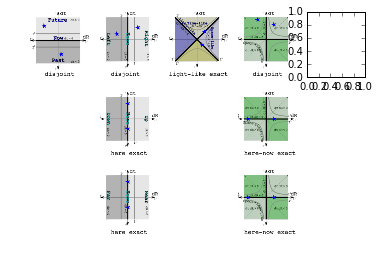

In [16]:
E1 = QH([0, 0, 0, 0])
E2 = QH([1,1,0,0])
E3 = QH([2,0, 0, 0])
eq_E12 = EQ(E1, E2)
eq_E13 = EQ(E1, E3)
eq_E23 = EQ(E2, E3)
print(eq_E12)
eq_E12.visualize()

In [ ]:
print(eq_E13)
eq_E13.visualize()

In [ ]:
print(eq_E23)
eq_E23.visualize()

In [35]:
q12 = Q8([1,2,0,0,0,0,0,0])
q12inv = q12.invert()
q1221 = q12.product(q12inv)
q1221n2 = q1221.norm_squared()
print(q12)
print(q12inv)
print(q1221)
print(q1221n2)
print(q1221n2.reduce())

(1, 2)_I0,2  (0, 0)_i1,3  (0, 0)_j1,3  (0, 0)_k1,3  Q
(1.0, 2.0)_I0,2  (0.0, 0.0)_i1,3  (0.0, 0.0)_j1,3  (0.0, 0.0)_k1,3  Q.^-1
(5.0, 4.0)_I0,2  (0.0, 0.0)_i1,3  (0.0, 0.0)_j1,3  (0.0, 0.0)_k1,3  QxQ.^-1
(41.0, 40.0)_I0,2  (0, 0)_i1,3  (0, 0)_j1,3  (0, 0)_k1,3  QxQ.^-1.norm_squared
(1.0, 0)_I0,2  (0, 0)_i1,3  (0, 0)_j1,3  (0, 0)_k1,3  QxQ.^-1.norm_squared.reduce
(1.0, 0)_I0,2  (0, 0)_i1,3  (0, 0)_j1,3  (0, 0)_k1,3  QxQ.^-1.norm_squared.reduce


In [31]:
Q12 = QH([1, 2,0, 0, 0, 0, 0,0])
Q12inv = Q12.invert()
Q1221 = Q12.product(Q12inv)
print(Q1221)

1.0t  0.0i  0.0j  0.0k  QxQ.^-1


In [47]:
q12 = Q8([1,2,0,0,0,0,0,0])
qcrazy = Q8([1,12,2,3,13,2,7,5])
print(q12.product(q12.invert()).reduce())
print(qcrazy.product(qcrazy.invert()).reduce())

(1.0, 0)_I0,2  (0.0, 0.0)_i1,3  (0.0, 0.0)_j1,3  (0.0, 0.0)_k1,3  QxQ.^-1.reduce
(1.0, 0)_I0,2  (0, 0)_i1,3  (0, 0)_j1,3  (0, 0)_k1,3  QxQ.^-1.reduce


In [48]:
print(q12)
print(q12.invert())
print(q12.product(q12.invert()))
print(q12.product(q12.invert()).norm_squared())

(1, 2)_I0,2  (0, 0)_i1,3  (0, 0)_j1,3  (0, 0)_k1,3  Q
(1.0, 2.0)_I0,2  (0.0, 0.0)_i1,3  (0.0, 0.0)_j1,3  (0.0, 0.0)_k1,3  Q.^-1
(5.0, 4.0)_I0,2  (0.0, 0.0)_i1,3  (0.0, 0.0)_j1,3  (0.0, 0.0)_k1,3  QxQ.^-1
(41.0, 40.0)_I0,2  (0, 0)_i1,3  (0, 0)_j1,3  (0, 0)_k1,3  QxQ.^-1.norm_squared


In [46]:
print(qcrazy.product(qcrazy.invert()).reduce())

(1.0, 0)_I0,2  (0, 0)_i1,3  (0, 0)_j1,3  (0, 0)_k1,3  QxQ.^-1.reduce


In [54]:
print(qcrazy.norm_squared())
print(qcrazy.invert().norm_squared())
print(q12.norm_squared().product(qcrazy.invert().norm_squared()))

(405, 158)_I0,2  (0, 0)_i1,3  (0, 0)_j1,3  (0, 0)_k1,3  Q.norm_squared
(0.006638364831418315, 0.0025897818354668986)_I0,2  (0, 0)_i1,3  (0, 0)_j1,3  (0, 0)_k1,3  Q.^-1.norm_squared
(0.04355095149895917, 0.039502368503007756)_I0,2  (0.0, 0.0)_i1,3  (0.0, 0.0)_j1,3  (0.0, 0.0)_k1,3  Q.norm_squaredxQ.^-1.norm_squared
